In [1]:
"""
    -- Description:
        
        This notebook applies Sequential Bootstrapping with mlfinlab.
        
        (1) We apply CUSUM filter to get events, and apply TBL labeling.
        
        (2) Sequantial Bootstrapping will be applied in the sampling process.
        
        (3) In sequantial bootstrap, each step of sampling maximizes the probabality 
        
        of the label which leads to the maximal uniqueness being drawn. It still 
        
        allows repetition, but with a adjusted, lower probability.
        
        (4) Adjustment based on absolute return and time decay is also considered.
        
    -- Prerequisite:
        
        Quandl Api Key
        
    -- Auther:
        
        Fang Fan (Roy)
        
    -- Date:
        
        September 20, 2020
    
""";

In [2]:
import pandas as pd
import numpy as np
import mlfinlab as ml
import seaborn as sns
import quandl
from sklearn.utils import resample
from mlfinlab.sampling.concurrent import get_av_uniqueness_from_triple_barrier
from mlfinlab.sampling.bootstrapping import get_ind_mat_average_uniqueness
from mlfinlab.sampling.bootstrapping import get_ind_matrix
from mlfinlab.sampling.bootstrapping import seq_bootstrap

In [3]:
quandl.ApiConfig.api_key = "okePP6eysAeuyx8BnX7k"

start_date = pd.to_datetime("2011-01-01")
end_date = pd.to_datetime("2018-01-01")

In [4]:
data = quandl.get("WIKI/AAPL.11", start_date=start_date, end_date=end_date)

In [5]:
data.head(3).append(data.tail(3))

,Adj. Close
Date,
2011-01-03,42.354338
2011-01-04,42.575382
2011-01-05,42.923655
2017-12-27,170.600000
2017-12-28,171.080000
2017-12-29,169.230000


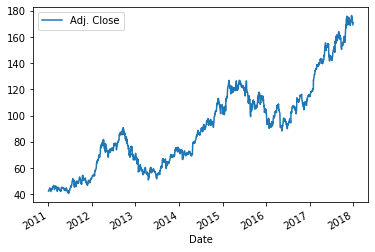

In [6]:
data.plot();

## Calculate Daily Volatility

In [7]:
daily_vol = ml.util.get_daily_vol(data["Adj. Close"], lookback=50).dropna()

In [8]:
daily_vol.head(3).append(daily_vol.tail(3))

Date
2011-01-06    0.004297
2011-01-07    0.003804
2011-01-10    0.005906
2017-12-27    0.014866
2017-12-28    0.014582
2017-12-29    0.014385
Name: Adj. Close, dtype: float64

## Apply CUSUM Filter | Get Timestamps for Events

In [9]:
# Set the average volatility as the CUSUM threshold
cusum_threshold = daily_vol.mean()

In [10]:
print(cusum_threshold)

0.020577125429405662


In [11]:
# Get timestamps for the events using CUSUM
cusum_events = ml.filters.cusum_filter(data["Adj. Close"], threshold=cusum_threshold)

In [12]:
cusum_events

DatetimeIndex(['2011-01-10', '2011-01-18', '2011-01-20', '2011-01-24',
               '2011-01-28', '2011-02-01', '2011-02-07', '2011-02-15',
               '2011-02-18', '2011-02-22',
               ...
               '2017-10-19', '2017-10-27', '2017-10-30', '2017-11-03',
               '2017-11-14', '2017-11-21', '2017-11-29', '2017-12-11',
               '2017-12-18', '2017-12-26'],
              dtype='datetime64[ns]', length=493, freq=None)

In [13]:
# CUSUM filter: Stats
print(cusum_events.shape[0])
print(data.shape[0])
print(cusum_events.shape[0] / data.shape[0])

493
1759
0.2802728823194997


## Triple Barrier Labeling

In [14]:
# For each timestamp in cusum_events, obtain its vertical barrier (h=10)
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events,
                                                     close=data['Adj. Close'],
                                                     num_days=10)

In [15]:
vertical_barriers.head(3)

2011-01-10   2011-01-20
2011-01-18   2011-01-28
2011-01-20   2011-01-31
Name: Date, dtype: datetime64[ns]

In [16]:
# TBL Barriers Calculation (first touching time)
pt_sl = [1, 2]
min_return = 0.005

In [17]:
barrier_events = ml.labeling.get_events(data["Adj. Close"], 
                                        t_events=cusum_events, 
                                        pt_sl=pt_sl, 
                                        target=daily_vol,
                                        min_ret=min_return, 
                                        num_threads=2, 
                                        vertical_barrier_times=vertical_barriers,
                                        verbose=False
                                       )
barrier_events.dropna(inplace=True)

In [18]:
barrier_events.head(3).append(barrier_events.tail(3))

,t1,trgt,pt,sl
2011-01-10,2011-01-13,0.005906,1,2
2011-01-18,2011-01-20,0.012874,1,2
2011-01-20,2011-01-25,0.018058,1,2
2017-11-29,2017-12-11,0.016845,1,2
2017-12-11,2017-12-18,0.015184,1,2
2017-12-18,2017-12-26,0.014226,1,2


## Average Uniqueness of Labels

In [19]:
av_unique = get_av_uniqueness_from_triple_barrier(triple_barrier_events=barrier_events, 
                                                  close_series=data["Adj. Close"],
                                                  num_threads=2, 
                                                  verbose=0
                                                 )

In [20]:
pd.concat([barrier_events,av_unique], axis=1).head()

,t1,trgt,pt,sl,tW
2011-01-10,2011-01-13,0.005906,1,2,1.000000
2011-01-18,2011-01-20,0.012874,1,2,0.833333
2011-01-20,2011-01-25,0.018058,1,2,0.625000
2011-01-24,2011-02-01,0.022417,1,2,0.619048
2011-01-28,2011-02-01,0.023666,1,2,0.444444


In [21]:
# Average uniqueness of all labels
print(av_unique.mean())

tW    0.670403
dtype: float64


In [22]:
# Unique labels count
unique_label_index = av_unique[av_unique["tW"]==1]
print(unique_label_index.shape)

(33, 1)


## Sequential Bootstrapping

In [23]:
# Get indicator matrix for barrier events (Another Form)
triple_barrier_ind_mat = get_ind_matrix(barrier_events, price_bars=data['Adj. Close'])

In [24]:
# Sequential Bootstrap Sampling
sample_length = int(1 * barrier_events.shape[0])
samples = seq_bootstrap(triple_barrier_ind_mat, sample_length=sample_length, verbose=0)

In [25]:
print(len(set(samples)))
print(samples[:10])

348
[118, 100, 423, 402, 146, 64, 247, 352, 286, 304]


## Breakdown of Sequential Bootstrapping: Probability Update

In [26]:
ind_mat = np.array([[1, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [27]:
# For each possible new sample, calculate the average uniqueness 
# The uniqueness score will be used to allocate the probablity for the label
# Higher uniqueness results in higher probability
phi = [1, 2]
uniqueness_array = np.array([None, None, None])

for i in range(0, 3):  
    ind_mat_with_new_sample = ind_mat[:, phi + [i]]
    uniqueness_array[i] = get_ind_mat_average_uniqueness(ind_mat_with_new_sample)
probability_array = uniqueness_array / np.sum(uniqueness_array)

In [28]:
print(uniqueness_array)
print(probability_array)

[0.8571428571428571 0.6666666666666666 0.6666666666666666]
[0.391304347826087 0.30434782608695654 0.30434782608695654]


## Compare Uniqueness of Sequential and Standard Bootstrap

In [29]:
n = 100
sample_length = 400
seq_uniqueness = []
standard_uniqueness = []

In [30]:
for _ in range(n):
    seq_samples = seq_bootstrap(triple_barrier_ind_mat, sample_length=sample_length)
    standard_samples = resample(np.arange(triple_barrier_ind_mat.shape[1]), n_samples=sample_length)
    
    seq_uniqueness.append(get_ind_mat_average_uniqueness(triple_barrier_ind_mat[:, seq_samples]))
    standard_uniqueness.append(get_ind_mat_average_uniqueness(triple_barrier_ind_mat[:, standard_samples]))

<AxesSubplot:>

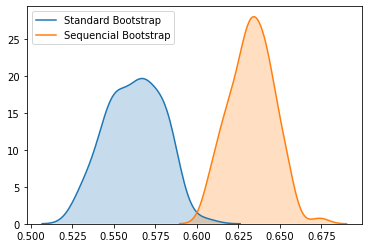

In [31]:
sns.kdeplot(np.array(standard_uniqueness), shade=True, label="Standard Bootstrap")
sns.kdeplot(np.array(seq_uniqueness), shade=True, label="Sequencial Bootstrap")

In [32]:
# The sequential bootstrap sampling provides higher uniqueness